In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


-Data is read in as row vectors, labels are one hot encoded row vectors as well<br>
-Data in CSV files are already z-scored, zero mean and std 1

-Update
Method of reading lines from csv is very slow, trying now to use memmaps for faster reads


In [5]:
#train_path = 'train.csv'
#train_labels_path = '../DATA/train_labels.pkl'

#test_path = 'test.csv'
#test_labels_path = '../DATA/test_labels.pkl'

#train data size (10404, 8269).T -> (8269,10404)
#test data size (10404, 2085).T -> (2085,10404)

class TumorDataset(Dataset):
    #reads in labels from dataframe and samples from csv 1 row at a time
    
    def __init__(self, labels_path, data_path, data_dims, genes_path, transform=None):
        labels_df = pd.read_pickle(labels_path)        
        self.labels = np.array(labels_df).astype(int).T
        self.data_memmap = np.memmap(data_path, dtype='float64', mode='r', shape=data_dims)
        self.genes = pd.read_csv(genes_path, nrows=1, index_col=0).columns.values
        self.transform = transform
    
    def __len__(self):
        return (self.labels).shape[0]
    
    def __getitem__(self, idx):
        #Single row read from the csv
        sample = self.data_memmap[idx,:]
        #sample = pd.read_csv(self.train_path, nrows=1, index_col=0, skiprows=range(0,idx)).values
        label = self.labels[idx,:]
        train_sample = {'data': sample, 'label': label}
        
        if self.transform:
            train_sample = self.transform(train_sample)
                        
        return train_sample

#Example Usage
#train = TumorDataset('train.csv', '../DATA/train_labels.pkl', transform = ToImage())
# train = TumorDataset('train.csv', '../DATA/train_labels.pkl', transform = transforms.Compose([ToImage(),ToTensor()]))
# len(train)
# sample = train[0]
# sample['data'](8269,10404)
# sample['label']

# test = TumorDataset('test.csv', '../DATA/test_labels.pkl')
# len(test)
# test_sample = test[0]
# test_sample['data']
# test_sample['label']    

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement __call__ method and if required, __init__ method. We can then use a transform like this:

tsfm = Transform(params)
<br>
transformed_sample = tsfm(sample)

In [6]:
class ToImage(object):
    
    """
    Maybe reordering here by gene position
    
    Follows the same image scaling as people in the paper.
    features_padded = features_train[i, :]/max(features_train[i, :])
    img = features_padded.reshape(102, 102)
    (img - 0.5)/0.5
    
    -Update
    -I switched this to having data already normalized (x-x.mean)/x.std
    -Only need reshape here
    """
    
    def __init__(self,annotation_file=None):
        self.file = annotation_file
    
    def __call__(self,sample):
        image, label = sample['data'], sample['label']
        image = np.reshape(image, (102,102))
        
        #add sorting later with annotation_file
        
        return {'data': image, 'label': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __call__(self, sample):
        image, label = sample['data'], sample['label']
        return {'data': torch.tensor(image), 'label': torch.tensor(label)}

## Weight initialization

For the dense layer which in pytorch is called linear for example, weights are initialized uniformly.

stdv = 1. / math.sqrt(self.weight.size(1))
<br>
self.weight.data.uniform_(-stdv, stdv)

https://github.com/pytorch/pytorch/tree/master/torch/nn/modules

In [7]:
class Net(nn.Module):

    def __init__(self, num_of_classes):
        super(Net, self).__init__()
        # input image channel, output channels, kernel size square convolution
        # kernel
        # input size = 102, output size = 100
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # input size = 50, output size = 48
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        # input size = 24, output size = 24
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.drop2D = nn.Dropout2d(p=0.25, inplace=False)
        self.vp = nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(256*12*12, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_of_classes)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.bn1(self.vp(self.conv1(x))))
        x = F.relu(self.bn2(self.vp(self.conv2(x))))
        x = F.relu(self.bn3(self.vp(self.conv3(x))))
        x = self.drop2D(x)
        x = x.view(in_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
Net(num_of_classes=33)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2D): Dropout2d(p=0.25)
  (vp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=33, bias=True)
)

In [8]:
num_epochs = 10
batch_size = 75
learning_rate = 0.0001

In [35]:
#Train set
labels_path = '../DATA/train_labels.pkl'
data_path = 'train.dat'
data_dims = (8269,10404)
genes_path = 'train.csv'

train = TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([ToImage(),ToTensor()]))

#Test set
labels_path = '../DATA/test_labels.pkl'
data_path = 'test.dat'
data_dims = (2085,10404)
genes_path = 'test.csv'

test = TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([ToImage(),ToTensor()]))

In [46]:
#Train data loader
dataloader_train = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)

#Test data loader
dataloader_test = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=4)

### New untrained network or loading weights

In [21]:
load_pretrained_weights = False

net = Net(num_of_classes=33)

if load_pretrained_weights:
    net.load_state_dict(torch.load('network_weights/epoch10_weights.pt'))

In [10]:
net.to(device)
net.double()

#Training loss function
criterion = nn.CrossEntropyLoss()

#Training optimizer
optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate)


### CNN input wants  (Batch, Number Channels, height, width)

### For Conv1d the input dimensions are defined as [batch, channel, length].


In [16]:
training_loss = []
validation_loss = []
for epoch in tqdm(range(num_epochs)):
    running_loss_tmp = 0.0
    test_loss_tmp = 0.0
    for i, sample in enumerate(dataloader_train):
    #for (i,(sample,test_sample)) in enumerate( zip(dataloader_train,dataloader_test) ):
        #Data
        images = sample['data'].to(device).requires_grad_()
        images = torch.unsqueeze(images,1)
        labels = sample['label'].to(device)
        _, labels = torch.max(labels,1) #converts from one hot to integer
        
        #Forward Pass
        outputs = net(images)
        
        #Backward Pass
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss_tmp += loss.data
        print("Epoch {} Batch {} loss is: {}".format(epoch, i, loss.data))
        
    epoch_training_loss = running_loss_tmp.item()/(i+1) #i + 1 since index starts from 0
    
    #Will try validation on testing set for now, dont do this BAD
#     for j, test_sample in enumerate(dataloader_test):
        
#         #Testing loss
#         images = test_sample['data'].to(device)
#         images = torch.unsqueeze(images,1)
#         labels = test_sample['label'].to(device)
#         _, labels = torch.max(labels,1)
        
#         #Forward Pass
#         outputs = net(images)
#         loss = criterion(outputs, labels)
#         test_loss_tmp += loss.data
        
#    epoch_validation_loss = test_loss_tmp.item()/(j+1)
        
    print('epoch', epoch, ':loss is', running_loss_tmp)
    training_loss.append(epoch_training_loss)
#    validation_loss.append(epoch_validation_loss)
    if (epoch > 3) and (abs(training_loss[epoch] - training_loss[epoch-1]) <= 0.0001) and (abs(training_loss[epoch - 1] - training_loss[epoch - 2]) <= 0.0001):
        break
print('training finished')



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 Batch 0 loss is: 3.6949144118659274
Epoch 0 Batch 1 loss is: 1.9629078373219468
Epoch 0 Batch 2 loss is: 2.3782188136741995
Epoch 0 Batch 3 loss is: 2.8534441242216233
Epoch 0 Batch 4 loss is: 1.821783206364665
Epoch 0 Batch 5 loss is: 1.6891893541990357
Epoch 0 Batch 6 loss is: 2.5286305137333023
Epoch 0 Batch 7 loss is: 2.0576371112676397
Epoch 0 Batch 8 loss is: 1.249639449765047
Epoch 0 Batch 9 loss is: 1.07702643967877
Epoch 0 Batch 10 loss is: 1.053161592690916
Epoch 0 Batch 11 loss is: 2.8973148938439874
Epoch 0 Batch 12 loss is: 1.9624846622797485
Epoch 0 Batch 13 loss is: 0.8719341751555466
Epoch 0 Batch 14 loss is: 1.2923626998972233
Epoch 0 Batch 15 loss is: 2.083457792217237
Epoch 0 Batch 16 loss is: 2.369770540248983
Epoch 0 Batch 17 loss is: 1.629602264649636
Epoch 0 Batch 18 loss is: 1.103853755555554
Epoch 0 Batch 19 loss is: 0.18678761242055286
Epoch 0 Batch 20 loss is: 1.5607218904780955
Epoch 0 Batch 21 loss is: 1.0720292690335236
Epoch 0 Batch 22 loss is: 0.



 10%|█         | 1/10 [02:05<18:46, 125.18s/it]

epoch 0 :loss is tensor(38.6294, device='cuda:0', dtype=torch.float64)
Epoch 1 Batch 0 loss is: 1.3590086279259452
Epoch 1 Batch 1 loss is: 1.2063180063494645
Epoch 1 Batch 2 loss is: 0.766050557628192
Epoch 1 Batch 3 loss is: 0.9187122665288701
Epoch 1 Batch 4 loss is: 1.11387154681375
Epoch 1 Batch 5 loss is: 1.2307164932945802
Epoch 1 Batch 6 loss is: 1.1220776275983022
Epoch 1 Batch 7 loss is: 0.8079309086016399
Epoch 1 Batch 8 loss is: 0.6226504860032505
Epoch 1 Batch 9 loss is: 0.5409050335642056
Epoch 1 Batch 10 loss is: 0.6295572673797584
Epoch 1 Batch 11 loss is: 1.1046575805199284
Epoch 1 Batch 12 loss is: 0.6573027330457143
Epoch 1 Batch 13 loss is: 0.5694736211161134
Epoch 1 Batch 14 loss is: 0.41198217039944834
Epoch 1 Batch 15 loss is: 0.8527089079506127
Epoch 1 Batch 16 loss is: 1.2199915788383358
Epoch 1 Batch 17 loss is: 0.42311971789945385
Epoch 1 Batch 18 loss is: 0.7195074725143248
Epoch 1 Batch 19 loss is: 0.03597649590540541
Epoch 1 Batch 20 loss is: 1.05182246019



 20%|██        | 2/10 [04:08<16:35, 124.50s/it]

epoch 1 :loss is tensor(14.3729, device='cuda:0', dtype=torch.float64)
Epoch 2 Batch 0 loss is: 0.7742888270235138
Epoch 2 Batch 1 loss is: 0.5868142551329641
Epoch 2 Batch 2 loss is: 0.20279319033202228
Epoch 2 Batch 3 loss is: 0.3678228868570122
Epoch 2 Batch 4 loss is: 0.7324831013434216
Epoch 2 Batch 5 loss is: 0.5144397567643121
Epoch 2 Batch 6 loss is: 0.5530905509229287
Epoch 2 Batch 7 loss is: 0.5760970626985948
Epoch 2 Batch 8 loss is: 0.629137887011966
Epoch 2 Batch 9 loss is: 0.32429799176631274
Epoch 2 Batch 10 loss is: 0.4696514897854845
Epoch 2 Batch 11 loss is: 0.4035540475089503
Epoch 2 Batch 12 loss is: 0.4209740233206097
Epoch 2 Batch 13 loss is: 0.48010050969876045
Epoch 2 Batch 14 loss is: 0.2575353341980561
Epoch 2 Batch 15 loss is: 0.4298565984576254
Epoch 2 Batch 16 loss is: 0.5480161063483403
Epoch 2 Batch 17 loss is: 0.20743956969020108
Epoch 2 Batch 18 loss is: 0.5058400880009131
Epoch 2 Batch 19 loss is: 0.008821438857356275
Epoch 2 Batch 20 loss is: 0.904356



 30%|███       | 3/10 [06:17<14:41, 126.00s/it]

epoch 2 :loss is tensor(8.4917, device='cuda:0', dtype=torch.float64)
Epoch 3 Batch 0 loss is: 0.6104205104466601
Epoch 3 Batch 1 loss is: 0.31685525364875133
Epoch 3 Batch 2 loss is: 0.06707077026017973
Epoch 3 Batch 3 loss is: 0.13836841637775868
Epoch 3 Batch 4 loss is: 0.40240156390195825
Epoch 3 Batch 5 loss is: 0.4130891974393825
Epoch 3 Batch 6 loss is: 0.6620336319365752
Epoch 3 Batch 7 loss is: 0.4227974687072849
Epoch 3 Batch 8 loss is: 0.35272702525987093
Epoch 3 Batch 9 loss is: 0.24396789737384844
Epoch 3 Batch 10 loss is: 0.431681870364684
Epoch 3 Batch 11 loss is: 0.2914343752242771
Epoch 3 Batch 12 loss is: 0.29063896882691814
Epoch 3 Batch 13 loss is: 0.15433650307324878
Epoch 3 Batch 14 loss is: 0.3241880751360394
Epoch 3 Batch 15 loss is: 0.3195823367540155
Epoch 3 Batch 16 loss is: 0.18350690930704655
Epoch 3 Batch 17 loss is: 0.14429602389777135
Epoch 3 Batch 18 loss is: 0.4225899646006565
Epoch 3 Batch 19 loss is: 0.006133865525332069
Epoch 3 Batch 20 loss is: 1.3



 40%|████      | 4/10 [08:22<12:33, 125.65s/it]

epoch 3 :loss is tensor(6.6970, device='cuda:0', dtype=torch.float64)
Epoch 4 Batch 0 loss is: 0.5974665519852419
Epoch 4 Batch 1 loss is: 0.22057934428611012
Epoch 4 Batch 2 loss is: 0.04438577896740692
Epoch 4 Batch 3 loss is: 0.18145989034495502
Epoch 4 Batch 4 loss is: 0.6397346434336967
Epoch 4 Batch 5 loss is: 0.6440779762141792
Epoch 4 Batch 6 loss is: 0.4310798948572733
Epoch 4 Batch 7 loss is: 0.20888291846524515
Epoch 4 Batch 8 loss is: 0.27076570273203887
Epoch 4 Batch 9 loss is: 0.323071866337163
Epoch 4 Batch 10 loss is: 0.2510889278796132
Epoch 4 Batch 11 loss is: 0.16770531071782685
Epoch 4 Batch 12 loss is: 0.18490224552937887
Epoch 4 Batch 13 loss is: 0.4155205478710574
Epoch 4 Batch 14 loss is: 0.18653142749386323
Epoch 4 Batch 15 loss is: 0.33426801231015885
Epoch 4 Batch 16 loss is: 0.18441649602238
Epoch 4 Batch 17 loss is: 0.11717601887330947
Epoch 4 Batch 18 loss is: 0.23459324055378067
Epoch 4 Batch 19 loss is: 0.006614249309788971
Epoch 4 Batch 20 loss is: 1.29



 50%|█████     | 5/10 [10:32<10:34, 126.89s/it]

epoch 4 :loss is tensor(4.7653, device='cuda:0', dtype=torch.float64)
Epoch 5 Batch 0 loss is: 0.4366528024719611
Epoch 5 Batch 1 loss is: 0.17716775509483423
Epoch 5 Batch 2 loss is: 0.025910557133814068
Epoch 5 Batch 3 loss is: 0.15976148806753293
Epoch 5 Batch 4 loss is: 0.2673320110537931
Epoch 5 Batch 5 loss is: 1.2556505203856758
Epoch 5 Batch 6 loss is: 0.8944559572150468
Epoch 5 Batch 7 loss is: 0.39402210764157247
Epoch 5 Batch 8 loss is: 0.429919916224863
Epoch 5 Batch 9 loss is: 0.28832364137560546
Epoch 5 Batch 10 loss is: 0.281641899985455
Epoch 5 Batch 11 loss is: 0.1446780984956693
Epoch 5 Batch 12 loss is: 0.09354699557870186
Epoch 5 Batch 13 loss is: 0.146213515353786
Epoch 5 Batch 14 loss is: 0.15475401602762182
Epoch 5 Batch 15 loss is: 0.321827421141414
Epoch 5 Batch 16 loss is: 0.47995941348145976
Epoch 5 Batch 17 loss is: 0.06487596202588738
Epoch 5 Batch 18 loss is: 0.25824527342529857
Epoch 5 Batch 19 loss is: 0.007366934184613949
Epoch 5 Batch 20 loss is: 0.127



 60%|██████    | 6/10 [12:42<08:31, 127.90s/it]

epoch 5 :loss is tensor(3.8850, device='cuda:0', dtype=torch.float64)
Epoch 6 Batch 0 loss is: 0.4260438417120355
Epoch 6 Batch 1 loss is: 0.13227356479014377
Epoch 6 Batch 2 loss is: 0.02901108364286132
Epoch 6 Batch 3 loss is: 0.16076634244157625
Epoch 6 Batch 4 loss is: 0.43425347184472346
Epoch 6 Batch 5 loss is: 0.437764938180594
Epoch 6 Batch 6 loss is: 0.5811987819728411
Epoch 6 Batch 7 loss is: 0.3627802463094132
Epoch 6 Batch 8 loss is: 0.2562565823279406
Epoch 6 Batch 9 loss is: 0.42898820631219736
Epoch 6 Batch 10 loss is: 0.26031035335548036
Epoch 6 Batch 11 loss is: 0.10311704814168496
Epoch 6 Batch 12 loss is: 0.05498491427860927
Epoch 6 Batch 13 loss is: 0.08584743699462831
Epoch 6 Batch 14 loss is: 0.5872006413095314
Epoch 6 Batch 15 loss is: 0.39112905523888314
Epoch 6 Batch 16 loss is: 0.10654841695103909
Epoch 6 Batch 17 loss is: 0.0638436697482177
Epoch 6 Batch 18 loss is: 0.22928260220540153
Epoch 6 Batch 19 loss is: 0.004219751115137704
Epoch 6 Batch 20 loss is: 1



 70%|███████   | 7/10 [14:52<06:25, 128.51s/it]

epoch 6 :loss is tensor(3.3533, device='cuda:0', dtype=torch.float64)
Epoch 7 Batch 0 loss is: 0.38263957651233993
Epoch 7 Batch 1 loss is: 0.09143579303489789
Epoch 7 Batch 2 loss is: 0.023392704660470127
Epoch 7 Batch 3 loss is: 0.19063935245955785
Epoch 7 Batch 4 loss is: 0.2963047110882004
Epoch 7 Batch 5 loss is: 0.2510494174083276
Epoch 7 Batch 6 loss is: 0.24985319935112926
Epoch 7 Batch 7 loss is: 0.23398869362529523
Epoch 7 Batch 8 loss is: 0.14061721510204037
Epoch 7 Batch 9 loss is: 0.5528056532944615
Epoch 7 Batch 10 loss is: 0.302040458687599
Epoch 7 Batch 11 loss is: 0.09866021404476356
Epoch 7 Batch 12 loss is: 0.12763290346141376
Epoch 7 Batch 13 loss is: 0.0954211084034921
Epoch 7 Batch 14 loss is: 0.2521612407431572
Epoch 7 Batch 15 loss is: 0.3302397791546572
Epoch 7 Batch 16 loss is: 0.2112716523566012
Epoch 7 Batch 17 loss is: 0.04854896630202918
Epoch 7 Batch 18 loss is: 0.21093448652052307
Epoch 7 Batch 19 loss is: 0.0046547048620763105
Epoch 7 Batch 20 loss is: 



 80%|████████  | 8/10 [17:02<04:18, 129.05s/it]

epoch 7 :loss is tensor(2.6539, device='cuda:0', dtype=torch.float64)
Epoch 8 Batch 0 loss is: 0.44280272284415795
Epoch 8 Batch 1 loss is: 0.1283137317818874
Epoch 8 Batch 2 loss is: 0.014739603457260652
Epoch 8 Batch 3 loss is: 0.16839917793490605
Epoch 8 Batch 4 loss is: 0.3146870752416705
Epoch 8 Batch 5 loss is: 0.4718072022517791
Epoch 8 Batch 6 loss is: 0.6113836090272755
Epoch 8 Batch 7 loss is: 0.3340120704478748
Epoch 8 Batch 8 loss is: 0.13696260191513868
Epoch 8 Batch 9 loss is: 0.3454075758702537
Epoch 8 Batch 10 loss is: 0.3583279865114128
Epoch 8 Batch 11 loss is: 0.12677621901987768
Epoch 8 Batch 12 loss is: 0.13342788458104304
Epoch 8 Batch 13 loss is: 0.07489297123996357
Epoch 8 Batch 14 loss is: 0.13942296826643313
Epoch 8 Batch 15 loss is: 0.2901094248024102
Epoch 8 Batch 16 loss is: 0.3203857419219877
Epoch 8 Batch 17 loss is: 0.037877953964014895
Epoch 8 Batch 18 loss is: 0.20281378508388218
Epoch 8 Batch 19 loss is: 0.002378845446901856
Epoch 8 Batch 20 loss is: 



 90%|█████████ | 9/10 [19:12<02:09, 129.19s/it]

epoch 8 :loss is tensor(1.6654, device='cuda:0', dtype=torch.float64)
Epoch 9 Batch 0 loss is: 0.44404972269640214
Epoch 9 Batch 1 loss is: 0.11589626355971677
Epoch 9 Batch 2 loss is: 0.01737403428753467
Epoch 9 Batch 3 loss is: 0.19902589161947262
Epoch 9 Batch 4 loss is: 0.40446026562069154
Epoch 9 Batch 5 loss is: 0.3750845336753389
Epoch 9 Batch 6 loss is: 0.6077860777999107
Epoch 9 Batch 7 loss is: 0.3264433444016172
Epoch 9 Batch 8 loss is: 0.2984584232334802
Epoch 9 Batch 9 loss is: 0.40591456135524623
Epoch 9 Batch 10 loss is: 0.1490617262277477
Epoch 9 Batch 11 loss is: 0.05300306505668972
Epoch 9 Batch 12 loss is: 0.05336798898915575
Epoch 9 Batch 13 loss is: 0.05938750102382489
Epoch 9 Batch 14 loss is: 0.2750210815207407
Epoch 9 Batch 15 loss is: 0.20848316518875395
Epoch 9 Batch 16 loss is: 0.20359396818256983
Epoch 9 Batch 17 loss is: 0.0599736383412549
Epoch 9 Batch 18 loss is: 0.2176888137883861
Epoch 9 Batch 19 loss is: 0.004052833888825305
Epoch 9 Batch 20 loss is: 0



100%|██████████| 10/10 [21:19<00:00, 128.68s/it]

Epoch 9 Batch 27 loss is: 0.4122991497747386
epoch 9 :loss is tensor(1.5846, device='cuda:0', dtype=torch.float64)


training finished


### Save model parameters and losses then plot

In [ ]:
torch.save(net.state_dict(), 'final_weights_round2.pt')

In [ ]:
import pickle
loss_list = [running_loss,testing_loss]
with open('losses.pkl', 'wb') as f:
    pickle.dump(loss_list, f)

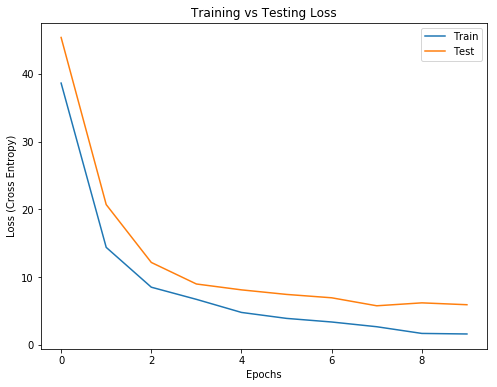

In [39]:
plt.ioff()
fig = plt.figure()
plt.plot(running_loss, label="Train")
plt.plot(testing_loss, label="Test")
plt.title("Training vs Testing Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
fig.set_size_inches(8, 6)
fig.savefig("Loss.png")

## Testing network

In [16]:
#Test set
labels_path = '../DATA/test_labels.pkl'
data_path = 'test.dat'
data_dims = (2085,10404)
genes_path = 'test.csv'

test = TumorDataset(labels_path,data_path,data_dims,genes_path,transform = transforms.Compose([ToImage(),ToTensor()]))

In [17]:
#Test data loader
#dataloader_test = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_test = DataLoader(test, batch_size=batch_size, num_workers=4)

In [13]:
load_final_weights = True

net = Net(num_of_classes=33)

if load_final_weights:
    net.load_state_dict(torch.load('network_weights/final_weights_batch75.pt'))

In [14]:
net.to(device)
net.double()
net.eval()
net.training

False

In [15]:
true_labels = np.array([])
labels_predicted = np.array([])

for ii, test_sample in enumerate(dataloader_test):
    #Data
    images = test_sample['data'].to(device)
    images = torch.unsqueeze(images,1)
    labels = test_sample['label'].to(device)
    _, labels = torch.max(labels,1)
    
    #Forward pass
    outputs = net(images)
    
    #Label classified
    _, predicted = torch.max(outputs.data, 1)
    
    true_labels = np.append(true_labels, labels.cpu().numpy().astype('int8'))
    labels_predicted = np.append(labels_predicted, predicted.cpu().numpy().astype('int8'))

In [16]:
accuracy = np.sum(true_labels==labels_predicted)
print(accuracy/len(true_labels))

0.9520383693045563


In [16]:
# for i, sample in enumerate(dataloader_train):
#     #Data
#     images = sample['data'].to(device)
#     images = torch.unsqueeze(images,1)
#     labels = sample['label']

# images[0:150].shape
# net(images[0:150])